# Project 2 Part 6 - Review Classification

#### Tasks

**Machine Learning**
- Create a text vectorizer
    - Select a sklearn vectorizer, remembering to consider preprocessing parameters and choices
- Build a Machine Learning Model
    - Build an sklearn modeling pipeline with text vectorizer and classification model. Again, remember to consider preprocessing parameters and choices
- Gridsearch Text Vectorization
    - Try to improve model by tuning text preprocessing steps
    - Fit and evaluate the grid search results
 
**Deep NLPs**
- Create train/test/val datasets
    - Convert target categories to integers
    - Create a tensorflow dataset using X and y
    - Split the dataset into training, test, and validation datasets
- Create a Keras Text Vectorization layer
    - Create a Keras layer for an RNN sequence model
    - Fit/adapt the text vectorization layer on training texts
    - Save the vocabulary size from the layer to use in the model's embedding layer
- Build an RNN with the TextVectorization Layer
    - Build and fit at least 1 sequence model
    - Evaluate the model on training and test data
    - Record observations

### Imports, Preparation

In [28]:
# Imports
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
import spacy
import nltk
import joblib

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

# Tensorflow
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import optimizers

# Random seed
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)

# Configuration
from sklearn import set_config
set_config(transform_output='pandas')    

In [2]:
%load_ext autoreload
%autoreload 2
import custom_functions as fn

In [3]:
df = joblib.load('data-NLP/reviews_processed.joblib')
df.head(1)

,review_id,movie_id,imdb_id,original_title,review,rating,highlow_rating,tokenized,lemmatized,tokenized_joined,lemmatized_joined
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love...",9.0,high,"[guilty, pleasure, personally, love, great, es...","[guilty, pleasure, personally, love, great, es...",guilty pleasure personally love great escape w...,guilty pleasure personally love great escape w...


In [4]:
# Drop any reviews that no not have a rating
df.isna().sum()

review_id            0
movie_id             0
imdb_id              0
original_title       0
review               0
rating               0
highlow_rating       0
tokenized            0
lemmatized           0
tokenized_joined     0
lemmatized_joined    0
dtype: int64

In [5]:
# Use original review column as X and classification target column as y
X = df['review']
y = df['highlow_rating']

In [6]:
#Train Test Split
X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=42)
y_train.value_counts(normalize=True)

low     0.510474
high    0.489526
Name: highlow_rating, dtype: float64

### Part 1 - Machine Learning

#### Build sklearn modeling pipeline with text vectorizer and classification model

In [7]:
## Build text vectorizer and classification model
# Create a sklearn text vectorizer. Consider stopwords, punc, etc.
tfidf_vectorizer = TfidfVectorizer(stop_words='english', lowercase=True)
# Create classification model
rf_clf = RandomForestClassifier()

In [8]:
# Create a sklearn modeling pipeline
ml_pipe = Pipeline([('vectorizer', tfidf_vectorizer),
                        ('classifier',rf_clf)])
ml_pipe

Pipeline(steps=[('vectorizer', TfidfVectorizer(stop_words='english')),
                ('classifier', RandomForestClassifier())])

In [9]:
# Fit and evaluate the model using the machine learning classification models from sklearn.
ml_pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(stop_words='english')),
                ('classifier', RandomForestClassifier())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        high       1.00      1.00      1.00       888
         low       1.00      1.00      1.00       926

    accuracy                           1.00      1814
   macro avg       1.00      1.00      1.00      1814
weighted avg       1.00      1.00      1.00      1814



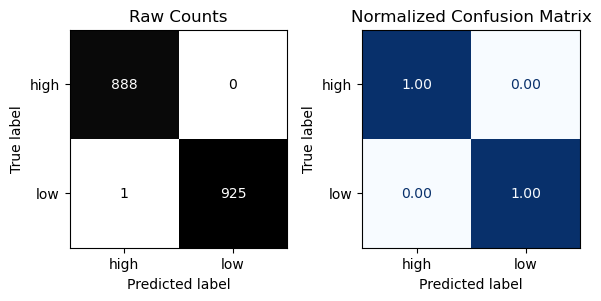


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        high       0.83      0.87      0.85       307
         low       0.86      0.81      0.83       298

    accuracy                           0.84       605
   macro avg       0.84      0.84      0.84       605
weighted avg       0.84      0.84      0.84       605



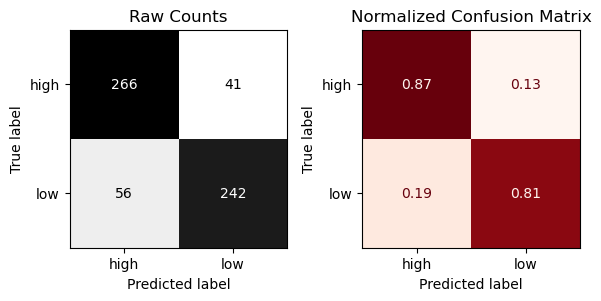

In [10]:
fn.evaluate_classification(ml_pipe, X_train, y_train, X_test, y_test)

- Our model started at 84 % accuracy, and was slightly better at predicting movies with a High rating.

#### Gridsearch Text Vectorization

Try different parameters for our text vectorization layer to try and improve model performance. Begin by finding possible parameters, and creating a grid of parameter options.

In [11]:
## Improve model by tuning preprocessing steps
# Construct grid of params for text vectorization step
# Check possible params
gscv_pipe = Pipeline([('vectorizer', TfidfVectorizer()),
                          ('classifier', RandomForestClassifier())])
gscv_pipe.get_params()

{'memory': None,
 'steps': [('vectorizer', TfidfVectorizer()),
  ('classifier', RandomForestClassifier())],
 'verbose': False,
 'vectorizer': TfidfVectorizer(),
 'classifier': RandomForestClassifier(),
 'vectorizer__analyzer': 'word',
 'vectorizer__binary': False,
 'vectorizer__decode_error': 'strict',
 'vectorizer__dtype': numpy.float64,
 'vectorizer__encoding': 'utf-8',
 'vectorizer__input': 'content',
 'vectorizer__lowercase': True,
 'vectorizer__max_df': 1.0,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 1,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__norm': 'l2',
 'vectorizer__preprocessor': None,
 'vectorizer__smooth_idf': True,
 'vectorizer__stop_words': None,
 'vectorizer__strip_accents': None,
 'vectorizer__sublinear_tf': False,
 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vectorizer__tokenizer': None,
 'vectorizer__use_idf': True,
 'vectorizer__vocabulary': None,
 'classifier__bootstrap': True,
 'classifier__ccp_alpha': 0.0,
 'classifier__class_weight

In [12]:
# Define params to try for both vectorizers
param_grid_shared = {
    "vectorizer__max_df": [0.7, 0.8, 0.9],
    'vectorizer__min_df': [ 2, 3, 4 ], 
    "vectorizer__max_features": [None, 1000, 2000],
}

# Define params for the count vectorizer
param_grid_count = {
    'vectorizer':[CountVectorizer()],
    **param_grid_shared,
}

# Define params for tfidf vectorizer 
param_grid_tfidf = {
    'vectorizer': [TfidfVectorizer()],
    "vectorizer__norm": ["l1", "l2"],
    "vectorizer__use_idf": [True, False],
    **param_grid_shared,
}

# Combine into list of params
vect_params_combined = [param_grid_count, param_grid_tfidf]

In [13]:
# Fit and eval grid search results
grid_search = GridSearchCV(gscv_pipe, vect_params_combined, cv=3, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 135 candidates, totalling 405 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid=[{'vectorizer': [CountVectorizer(max_df=0.7, min_df=3)],
                          'vectorizer__max_df': [0.7, 0.8, 0.9],
                          'vectorizer__max_features': [None, 1000, 2000],
                          'vectorizer__min_df': [2, 3, 4]},
                         {'vectorizer': [TfidfVectorizer()],
                          'vectorizer__max_df': [0.7, 0.8, 0.9],
                          'vectorizer__max_features': [None, 1000, 2000],
                          'vectorizer__min_df': [2, 3, 4],
                          'vectorizer__norm': ['l1', 'l2'],
                          'vectorizer__use_idf': [True, False]}],
             verbose=1)

In [14]:
# What are best params?
grid_search.best_params_

{'vectorizer': CountVectorizer(max_df=0.7, min_df=3),
 'vectorizer__max_df': 0.7,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 3}

Now that we have our best parameters, use them to create a new model and evaluate the performance.

**Evaluate best model**

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        high       1.00      1.00      1.00       888
         low       1.00      1.00      1.00       926

    accuracy                           1.00      1814
   macro avg       1.00      1.00      1.00      1814
weighted avg       1.00      1.00      1.00      1814



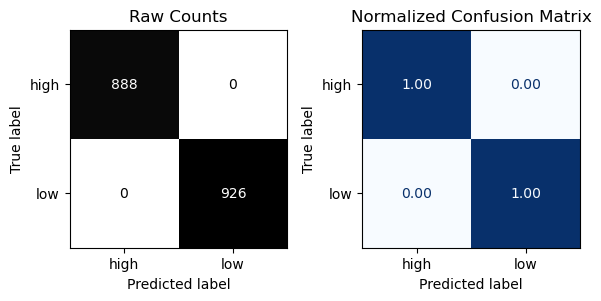


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        high       0.83      0.85      0.84       307
         low       0.84      0.82      0.83       298

    accuracy                           0.84       605
   macro avg       0.84      0.84      0.84       605
weighted avg       0.84      0.84      0.84       605



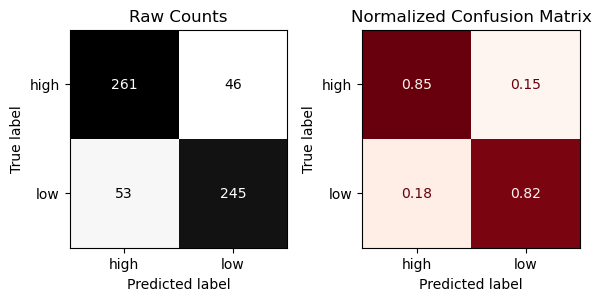

In [15]:
# Define best model
best_model = grid_search.best_estimator_

# Evaluate best model
fn.evaluate_classification(best_model, X_train, y_train, X_test, y_test)

The new model did not perform significantly better than the first, with accuracy staying the same and number of mislabeled movies staying within a couple of the original.

### Part 2 - Deep NLP (RNNs)

#### Creating Train, Test, Validation Datasets

In [20]:
## Convert y to integer values using LabelEncoder()
# Check y values
y.value_counts()

low     1224
high    1195
Name: highlow_rating, dtype: int64

In [25]:
# Convert to integer
labeler = LabelEncoder()
df['highlow_rating'] = labeler.fit_transform(df['highlow_rating'])
y = df['highlow_rating']
y.value_counts()

1    1224
0    1195
Name: highlow_rating, dtype: int64

In [29]:
# Convert to Dataset Object
ds = tf.data.Dataset.from_tensor_slices((X, y))
# Shuffle dataset
ds = ds.shuffle(buffer_size=len(ds), reshuffle_each_iteration=False)

In [30]:
# Set the ratio of the train, validation, test split
split_train = .7
split_val =  .2
split_test =  1 -( split_train + split_val )
# Calculate the number of samples for training and validation data 
n_train_samples =  int(len(ds) * split_train)
n_val_samples = int(len(ds) * split_val)
n_test_samples = len(ds) -(n_train_samples + n_val_samples)

# Set the batch size
BATCH_SIZE =32
# How many batches? 
import math # math.ceil will round up
n_train_batches = math.ceil(n_train_samples/BATCH_SIZE)
n_val_batches = math.ceil(n_val_samples/BATCH_SIZE)
n_test_batches = math.ceil(n_test_samples/BATCH_SIZE)
print(f"    - train:\t{n_train_samples} samples \t({n_train_batches} batches)")
print(f"    - val:  \t{n_val_samples} samples \t({n_val_batches} batches)")
print(f"    - test: \t{n_test_samples} samples \t({n_test_batches} batches)")

    - train:	1693 samples 	(53 batches)
    - val:  	483 samples 	(16 batches)
    - test: 	243 samples 	(8 batches)


In [34]:
# Use take and skip to define each set
train_ds = ds.take(n_train_samples).batch(batch_size=BATCH_SIZE)
val_ds = ds.skip(n_train_samples).take(n_val_samples).batch(batch_size=BATCH_SIZE)
test_ds = ds.skip(n_train_samples + n_val_samples).batch(batch_size=BATCH_SIZE)

# Confirm the number of batches in each
print (f' There are {len(train_ds)} training batches.')
print (f' There are {len(val_ds)} validation batches.')
print (f' There are {len(test_ds)} testing batches.')

 There are 53 training batches.
 There are 16 validation batches.
 There are 8 testing batches.


#### Creating a Keras Vectorization Layer

In [35]:
# Create keras text vect layer for RNN sequence model
SEQUENCE_LENGTH = 100
sequence_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH
)

In [59]:
# Get just the text from ds_train
ds_texts = train_ds.map(lambda x, y: x)
# Preview the text
# ds_texts.take(1).get_single_element()

In [40]:
# Train model
sequence_vectorizer.adapt(ds_texts)

In [54]:
# Getting list of vocab
vocab = sequence_vectorizer.get_vocabulary()
int_to_str = {idx: word for idx, word in enumerate(vocab)}

In [41]:
# Programmatically define size of vocab from vectorization layer
VOCAB_SIZE = sequence_vectorizer.vocabulary_size()
VOCAB_SIZE

24923

#### Build an RNN with the Text Vectorization Layer

In [49]:
# Define classes variable
classes = y.unique()
classes

array([0, 1], dtype=int64)

In [55]:
# Build an RNN with textVector layer
def build_bidir_GRU(text_vectorization_layer):
    
    model = tf.keras.Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE, 
                         output_dim=250, 
                         input_length=SEQUENCE_LENGTH)])

    # Two bidirectional GrU layers    
    model.add(layers.Bidirectional(layers.GRU(128, return_sequences=True)))
    model.add(layers.Dropout(.5))
    model.add(layers.Bidirectional(layers.GRU(64, return_sequences=True)))
    model.add(layers.Dropout(.5))
    model.add(layers.GlobalMaxPooling1D())
    
    # Output layer
    model.add(layers.Dense(len(classes), activation='sigmoid'))
    
    # Compile
    optimizer = optimizers.legacy.Adam()
    model.compile(optimizer=optimizer,  
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    model.summary()
    return model

In [56]:
# Include callbacks
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

In [57]:
# Build model
model = build_bidir_GRU(sequence_vectorizer)

EPOCHS = 30
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 100)              0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, 100, 250)          6230750   
                                                                 
 bidirectional_4 (Bidirectio  (None, 100, 256)         291840    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 100, 256)          0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 100, 128)         123648    
 nal)                                                            
                                                      

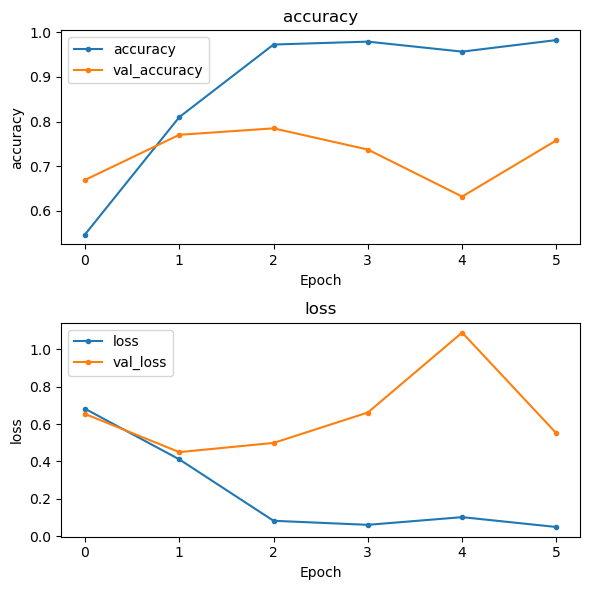


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       856
           1       1.00      1.00      1.00       837

    accuracy                           1.00      1693
   macro avg       1.00      1.00      1.00      1693
weighted avg       1.00      1.00      1.00      1693



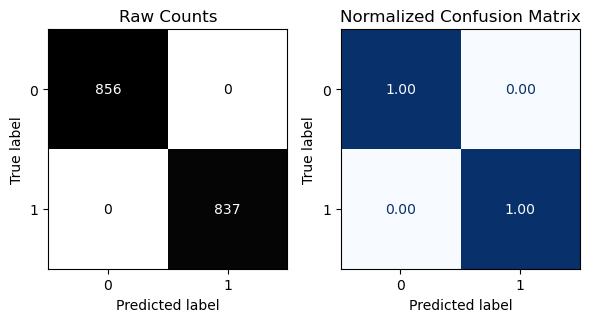


- Evaluating Training Data:
53/53 [==============================] - 2s 34ms/step - loss: 0.0210 - accuracy: 1.0000
{'loss': 0.020963935181498528, 'accuracy': 1.0}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.64      0.77      0.70       113
           1       0.76      0.63      0.69       130

    accuracy                           0.70       243
   macro avg       0.70      0.70      0.70       243
weighted avg       0.71      0.70      0.69       243



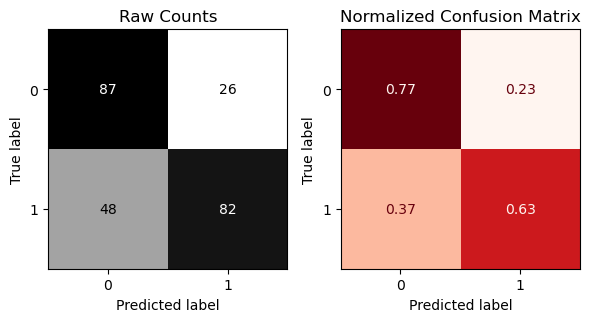


- Evaluating Test Data:
8/8 [==============================] - 0s 33ms/step - loss: 0.6516 - accuracy: 0.6955
{'loss': 0.6515693664550781, 'accuracy': 0.6954732537269592}


In [58]:
# Evaluate the model
results = fn.evaluate_classification_network(
    model, X_train=train_ds, X_test=test_ds, history=history);

- The RNN model did not perform as well as the previous models. The accuracy decreased and loss increased after only a few epochs as the model became overfit on the training data.
- The RNN model was particularly weak at predicting Low-rated movies, mislabeling over a third as High-rated.
- Given the performance of these models I would chose the second model, with GridSearchCV's best params, for use.